# MNIST Dataset with Softmax

In this notebook, we will demonstrate how to use the JLNN to build a simple Multi-layer Perceptron to classify the MNIST dataset. First we will import all the required modules. We use `PyPlot` to plot the visualizations. We will also import necessary layers and a network essembler `SquentialNet` to build our simple architecture.

In [1]:
Pkg.update()
Pkg.add("MNIST")
using PyPlot

INFO: Updating METADATA...
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Nothing to be done


In [2]:
include("layers/SoftMaxCrossEntropy.jl")
include("layers/SquareLossLayer.jl")
include("layers/FCLayer.jl")
include("layers/DropoutLayer.jl")
include("layers/ReLu.jl")
include("layers/Tanh.jl")
include("layers/SequnetialNet.jl")

([2.40761,1.31818],[2,1])
[0.244728 -0.909969 0.665241; 0.00490169 0.727475 -0.732377]
Diff: [0.0; 0.0; 2.0; 5.0]
(
[14.5],

[-1; 1; 1; 1])
dldy:[0.0; 0.0; 2.0; 5.0]
[0.0; 0.0; 2.0; 5.0]
FCLayer(2,[-2.45864 -0.727429 1.79938; -0.461796 2.16415 -2.80135; 0.0 0.0 0.0],[0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0])
[3.0 22.0 21.0; 7.0 46.0 45.0]
[56.0 110.0; 74.0 144.0]
[26.0 30.0 34.0; 38.0 44.0 50.0; 12.0 14.0 16.0]
[1.0 2.0; 0.0 3.0; 1.0 0.0; 0.0 0.0]
[2.0 3.0; 0.0 5.0; 3.0 0.0; 0.0 0.0]
[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]
[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


backward (generic function with 7 methods)

In [36]:
using MNIST
function mnistData()
    features = trainfeatures(1)
    label = trainlabel(1)

    trainX, trainY = traindata()
    N = size(trainX)[2]
    idx = randperm(N)
    trainX = trainX[:, idx]'
    trainY = trainY[idx]

    testX, testY = testdata()
    N = size(testX)[1]
    idx = randperm(N)
    testX = testX[:, idx]'
    testY = testY[idx]

    ttl = 55000
    trX, trY = trainX[1:ttl,:], trainY[1:ttl,:]

    @assert size(trX)[1] == size(trY)[1]
    println(size(trX), size(trY))

    trX = trX / 256. 
    return trX, trY
end
trainX, trainY = mnistData()


(55000,784)(55000,1)


(
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],

[1.0; 1.0; … ; 5.0; 9.0])

# Data Split

We split the data such the first 80% of the data would be for training, the rest first 10% would be for testing and 10% would be for validation.

In [37]:
function datasplit(trX, trY)
    local N = size(trY)[1]
    local size_training = convert(Int, N * 8/10)
    local size_testing = convert(Int, N / 10)
    local train_set = (trX[1:size_training,:],trY[1:size_training,:])
    local test_set = (trX[size_training + 1:size_training + size_testing, :], 
                                trY[size_training + 1 : size_training + size_testing, :])
    local validation_set =  (trX[size_training + size_testing + 1:N, :], 
                                    trY[size_training + size_testing + 1:N,:])
    return train_set, test_set, validation_set
end

train_set, test_set, validation_set = datasplit(trainX, trainY)
trX, trY = train_set[1], train_set[2]
valX, valY = validation_set[1], validation_set[2]
teX, teY = test_set[1], test_set[2]

(
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],

[1.0; 3.0; … ; 1.0; 8.0])

In [44]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end
function train(net::SequentialNet, X, Y; batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * gradient(layer) / batch_size
                local theta = getParam(layer) - gradi
                if verbose > 2
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size
            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        v_loss, v_pred = forward(net, valX, valY)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pred, valY) / v_size
        append!(val_losses, mean(v_loss))
        append!(val_accu,   v_accu)
        if epo % 10 == 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
            println("Validation accuracy : $(v_accu)")
        end
        if verbose > 0
            println("Epo $(epo) has loss :$(mean(epo_loss))\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses,epo_accus,val_losses,val_accu
end

train (generic function with 1 method)

In [35]:
function build_mlp_without_dropout()
    layers = Layer[ FCLayer(784, 10) ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end
net = build_mlp_without_dropout()

SequentialNet(Layer[FCLayer(784,[-0.430464 0.32231 … -0.300204 -0.166538; -0.417345 -0.0444619 … -0.0753175 -0.266219; … ; -0.371325 -0.601571 … 0.163912 -0.393159; 0.0 0.0 … 0.0 0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])],SoftMaxCrossEntropyLoss(Float64[],Float64[],#undef))

# Training

In this section, we train our network to learn the MNIST dataset. The network is consist of one FC layer, one cross-Entropy with soft max layer, and one sequential net. 

Epo 10 has loss :0.4723283891081961		accuracy : 0.8635227272727273
Validation accuracy : 0.8707272727272727
Epo 20 has loss :0.3994070222710943		accuracy : 0.885
Validation accuracy : 0.891090909090909
Epo 30 has loss :0.36853952153369773		accuracy : 0.8947272727272727
Validation accuracy : 0.899090909090909
Epo 40 has loss :0.350198643077511		accuracy : 0.9011590909090909
Validation accuracy : 0.903090909090909
Epo 50 has loss :0.3375858306952246		accuracy : 0.9050909090909091
Validation accuracy : 0.9067272727272727
Epo 60 has loss :0.3281703878548759		accuracy : 0.9080454545454546
Validation accuracy : 0.9089090909090909
Epo 70 has loss :0.32076219525479865		accuracy : 0.9103636363636364
Validation accuracy : 0.9109090909090909
Epo 80 has loss :0.3147164483043449		accuracy : 0.9123181818181818
Validation accuracy : 0.9109090909090909
Epo 90 has loss :0.30964858069308215		accuracy : 0.9142272727272728
Validation accuracy : 0.9112727272727272
Epo 100 has loss :0.3053126026034277		accu

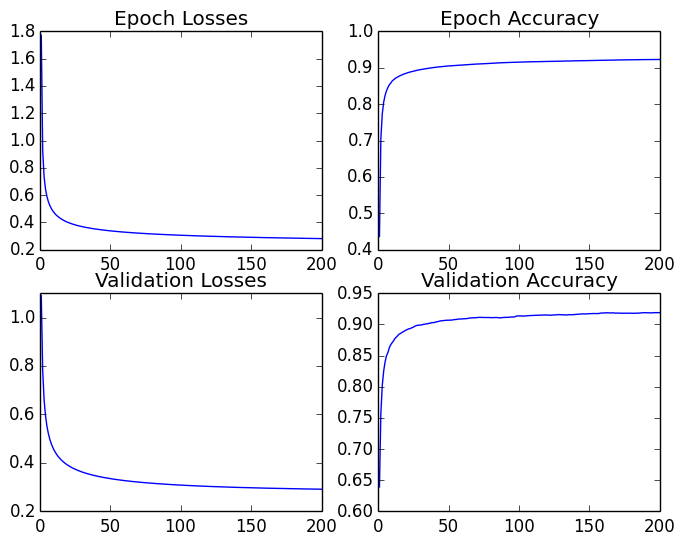

Epo 200 has loss :0.280830830133177		accuracy : 0.9229090909090909
Validation accuracy : 0.9189090909090909


In [65]:
net = build_mlp_without_dropout()

losses,accus,val_losses,val_accus = train(net, trX, trY, ttl_epo = 200; batch_size = 100,
         lrSchedule = x -> 0.01, verbose=0, alpha=0.9)
subplot(221)
plot(1:length(losses), losses)
title("Epoch Losses")

subplot(222)
plot(1:length(accus), accus)
title("Epoch Accuracy")
show()

subplot(223)
plot(1: length(val_losses), val_losses)
title("Validation Losses")
show()


subplot(224)
plot(1: length(val_accus), val_accus)
title("Validation Accuracy")
show()


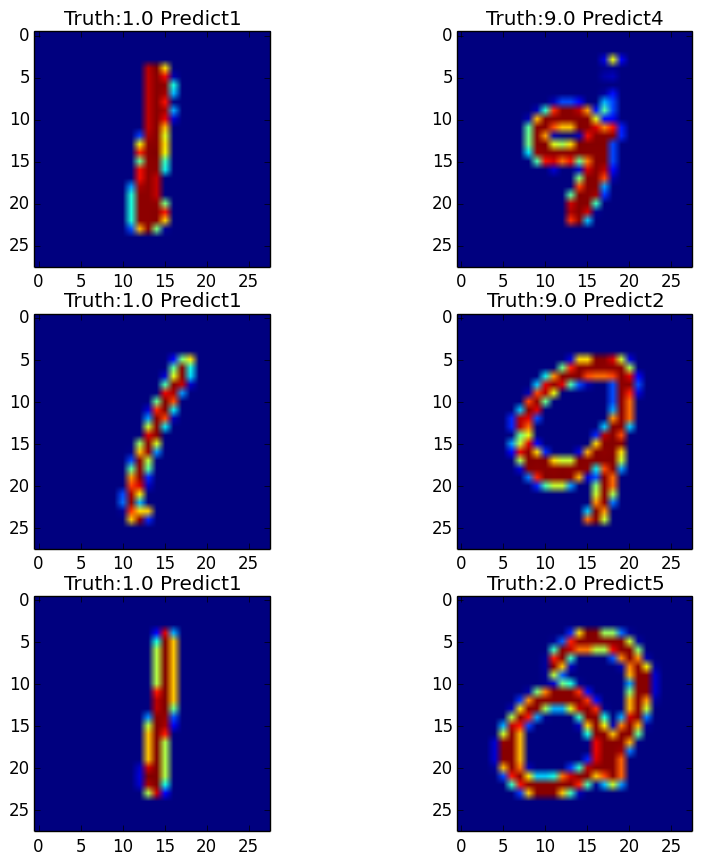

PyObject <matplotlib.text.Text object at 0x3196f3f90>

In [63]:
_, pred = forward(net, trX, trY; deterministics = true)
N = size(trX)[1]
right_idx = filter(i-> abs(pred[i] - trY[i]) <  1e-5, 1:N)[1:3]
wrong_idx = filter(i-> abs(pred[i] - trY[i]) >= 1e-5, 1:N)[1:3]

figure(figsize=(10,10))
subplot(321)
imshow(reshape(trX[right_idx[1],:], 28,28))
title("Truth:$(trY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(trX[wrong_idx[1],:], 28,28))
title("Truth:$(trY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(trX[right_idx[2],:], 28,28))
title("Truth:$(trY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(trX[wrong_idx[2],:], 28,28))
title("Truth:$(trY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(trX[right_idx[3],:], 28,28))
title("Truth:$(trY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(trX[wrong_idx[3],:], 28,28))
title("Truth:$(trY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")